In [1]:
from torch.optim import lr_scheduler
from torch.optim import SGD


from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

In [2]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)


bs = 256
@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - 0.29) / 0.35 for o in b['image']]

tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

x_mean = xb.mean((1,2,3), keepdim=True)
x_std = xb.std((1,2,3), keepdim=True)

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
from miniai.init import GeneralRelu

In [4]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from miniai.sgd import get_model, conv


In [5]:
from miniai.activations import Callback
from torch.optim.lr_scheduler import CosineAnnealingLR

class BaseSchedulerCB(Callback):
    def __init__(self, sched):
        self.sched = sched
    def before_fit(self, learn):
        self.schedo = self.sched(learn.opt)
        
    def step(self, learn):
        if learn.training: self.schedo.step()
            
class BatchSchedulerCB(BaseSchedulerCB):
    def after_batch(self, learn): self.step(learn)

class EpochSchedulerCB(BaseSchedulerCB):
    def after_epoch(self, learn): self.step(learn)

        
class StatisticCB(Callback):
    def __init__(self, **fs):
        self.stats = [[] for f in fs]
        self.fs = fs

    def after_batch(self, learn):
        for i, f in enumerate(self.fs):
            self.stats[i].append(self.fs[f](learn.opt.param_groups[0]))
        
    def plot(self):
        for name, y in zip(self.fs, self.stats):
            plt.plot(y, marker='o', linestyle='-')
            plt.xlabel('epoch')
            plt.ylabel('name')
            plt.title('name')
            plt.show()
    
def _lr(param_groups): return param_groups['lr']
def _mom(param_groups): return param_groups['betas'][0]

In [6]:
from miniai.conv import def_device

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [8,16,32,64,128]
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [7]:
# def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
#     if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
#     layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
#     if norm: layers.append(norm(nf))
#     if act: layers.append(act())
#     return nn.Sequential(*layers)

accuracy,loss,epoch,train
0.834,0.464,0,train
0.856,0.411,0,eval
0.882,0.323,1,train
0.848,0.419,1,eval
0.904,0.265,2,train
0.894,0.287,2,eval
0.926,0.200,3,train
0.914,0.231,3,eval
0.948,0.140,4,train
0.924,0.216,4,eval


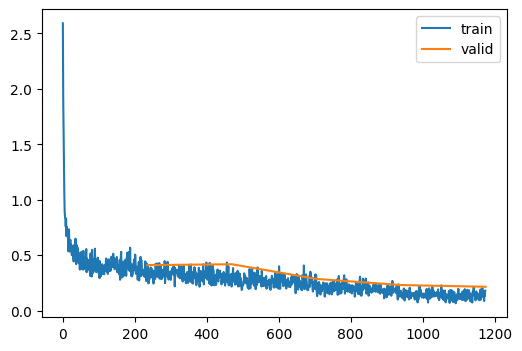

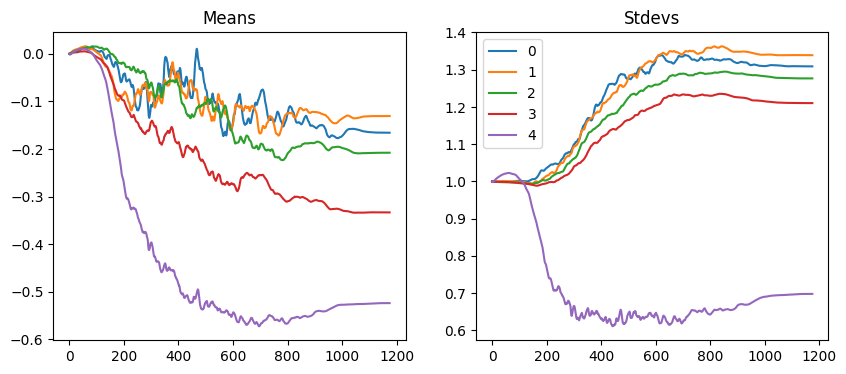

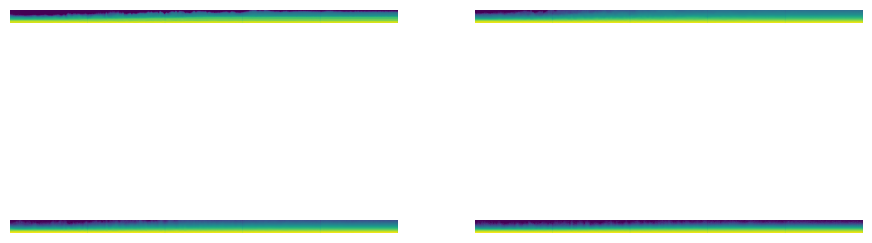

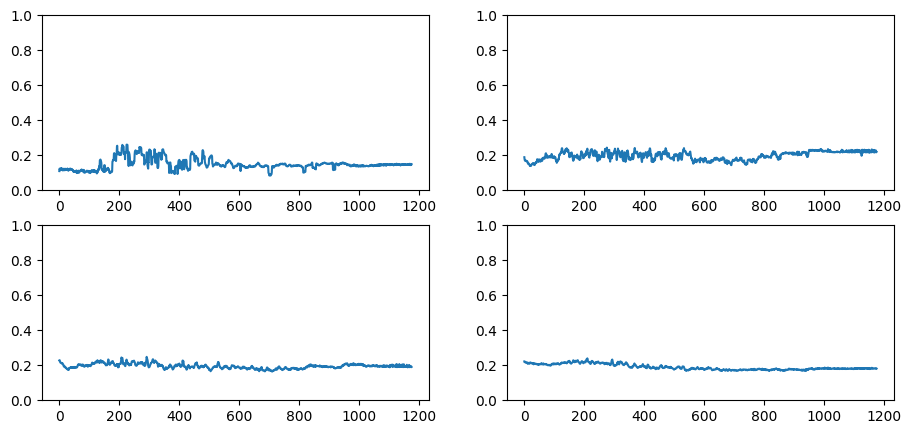

In [8]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
from miniai.init import init_weights 
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from functools import partial


max_lr = 6e-2  # Maximum learning rate
total_batchs = 5 * len(dt) # Total number of training epochs
pct_start = 0.3  # Percentage of epochs for increasing the learning rate
scheduler = partial(OneCycleLR, max_lr=max_lr, total_steps=total_batchs, pct_start=pct_start)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
stats = StatisticCB(lr=_lr, momentum=_mom)


cbs = [stats, DeviceCB(), metrics, ProgressCB(plot=True), visual, BatchSchedulerCB(scheduler)]
model = get_model(act=nn.LeakyReLU , norm=nn.BatchNorm2d).apply(partial(init_weights, leaky=0.01))
learn = Learner(model, dls, F.cross_entropy, lr=6e-2,cbs=cbs, opt_func=torch.optim.AdamW)
learn.fit(5)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [15]:
from miniai.conv import def_device


class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
        super(ResidualBlock, self).__init__()
        
        conv1 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm, bias=bias)
        conv2 = conv(nf, nf, ks=ks, stride=stride, act=act, norm=norm, bias=0)
        conv2[0].weight.data.fill_(0)
        
        idd = []
        if stride != 1: idd.append(nn.AvgPool2d(kernel_size=2, stride=stride, ceil_mode=True))
        if ni != nf: idd.append(nn.Conv2d(ni, nf, kernel_size=1, bias=None))

        if idd:
            adapter = nn.Sequential(*idd)
        else:
            adapter = nn.Identity()

        self.conv = nn.Sequential(conv1, conv2)
        self.adapter = adapter
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.conv(x) + self.adapter(x))

def get_resnet_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [8,16,32,64,128]
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResidualBlock(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.823,0.505,0,train
0.862,0.399,0,eval
0.869,0.362,1,train
0.867,0.371,1,eval
0.890,0.303,2,train
0.885,0.316,2,eval
0.904,0.262,3,train
0.893,0.283,3,eval
0.920,0.216,4,train
0.909,0.240,4,eval


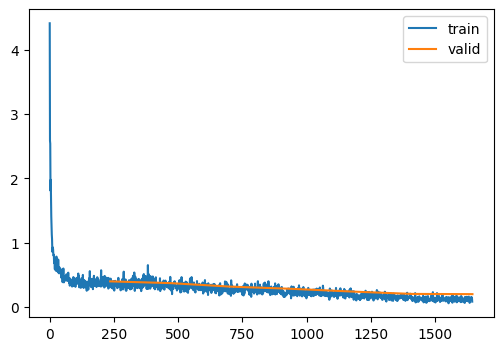

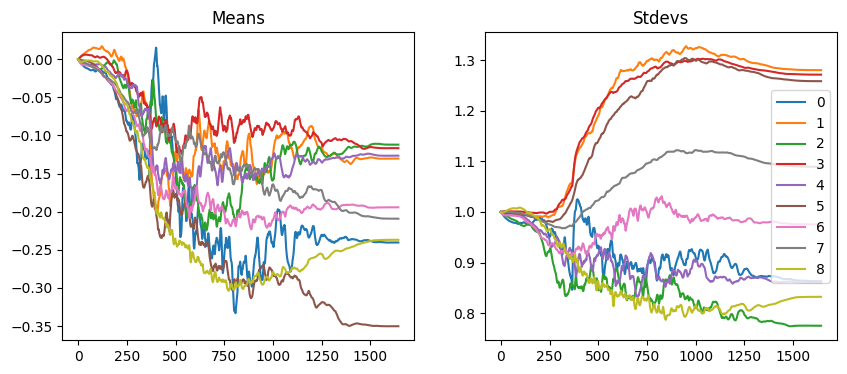

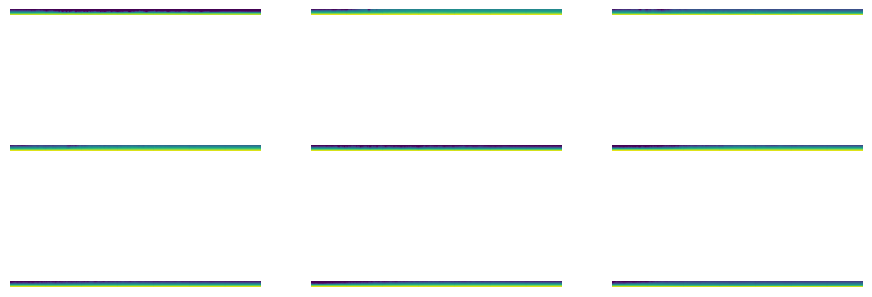

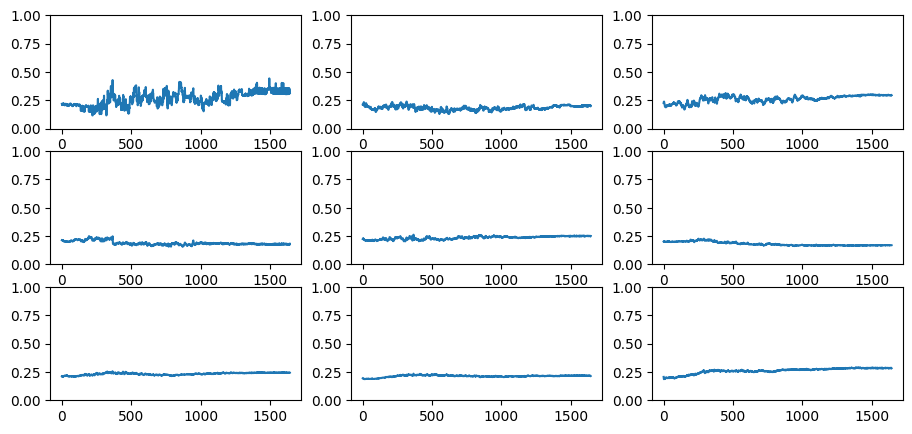

In [24]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
from miniai.init import init_weights 
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from functools import partial


max_lr = 6e-2  # Maximum learning rate
total_batchs = 7 * len(dt) # Total number of training epochs
pct_start = 0.3  # Percentage of epochs for increasing the learning rate
scheduler = partial(OneCycleLR, max_lr=max_lr, total_steps=total_batchs, pct_start=pct_start)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
stats = StatisticCB(lr=_lr, momentum=_mom)


cbs = [stats, DeviceCB(), metrics, ProgressCB(plot=True), visual, BatchSchedulerCB(scheduler)]
model = get_resnet_model(act=nn.LeakyReLU , norm=nn.BatchNorm2d).apply(partial(init_weights, leaky=0.01))
learn = Learner(model, dls, F.cross_entropy, lr=max_lr,cbs=cbs, opt_func=torch.optim.AdamW)
learn.fit(7)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()